# Compute distances (different versions)

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [3]:
# Setup for varying N (keeping K and D constant)
D = 128
Ns = [1<<i for i in range(2, 15)]

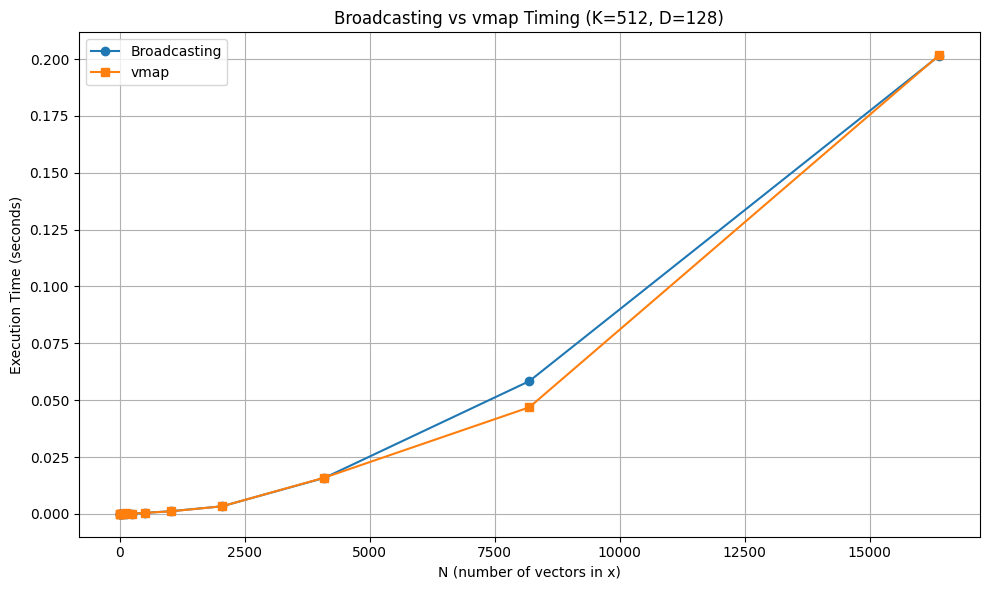

In [5]:
broadcast_times = []
vmap_times = []

# Benchmark each size
for N in Ns:
    key = jax.random.PRNGKey(0)
    x = jax.random.normal(key, (N, D))
    y = jax.random.normal(key, (N, D))

    @jax.jit
    def compute_norm_broadcast(x, y):
        x_i = x[:, None, :]
        y_j = y[None, :, :]
        return jnp.sum((x_i - y_j) ** 2, axis=-1)

    @jax.jit
    def compute_norm_vmap(x, y):
        def squared_euclidean(xi):
            return jnp.sum((xi - y) ** 2, axis=1)

        return jax.vmap(squared_euclidean)(x)

    # Warm-up
    _ = compute_norm_broadcast(x, y).block_until_ready()
    _ = compute_norm_vmap(x, y).block_until_ready()

    # Time broadcasting
    start = time.time()
    _ = compute_norm_broadcast(x, y).block_until_ready()
    broadcast_times.append(time.time() - start)

    # Time vmap
    start = time.time()
    _ = compute_norm_vmap(x, y).block_until_ready()
    vmap_times.append(time.time() - start)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(Ns, broadcast_times, marker="o", label="Broadcasting")
plt.plot(Ns, vmap_times, marker="s", label="vmap")
plt.xlabel("N (number of vectors in x)")
plt.ylabel("Execution Time (seconds)")
plt.title("Broadcasting vs vmap Timing (K=512, D=128)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

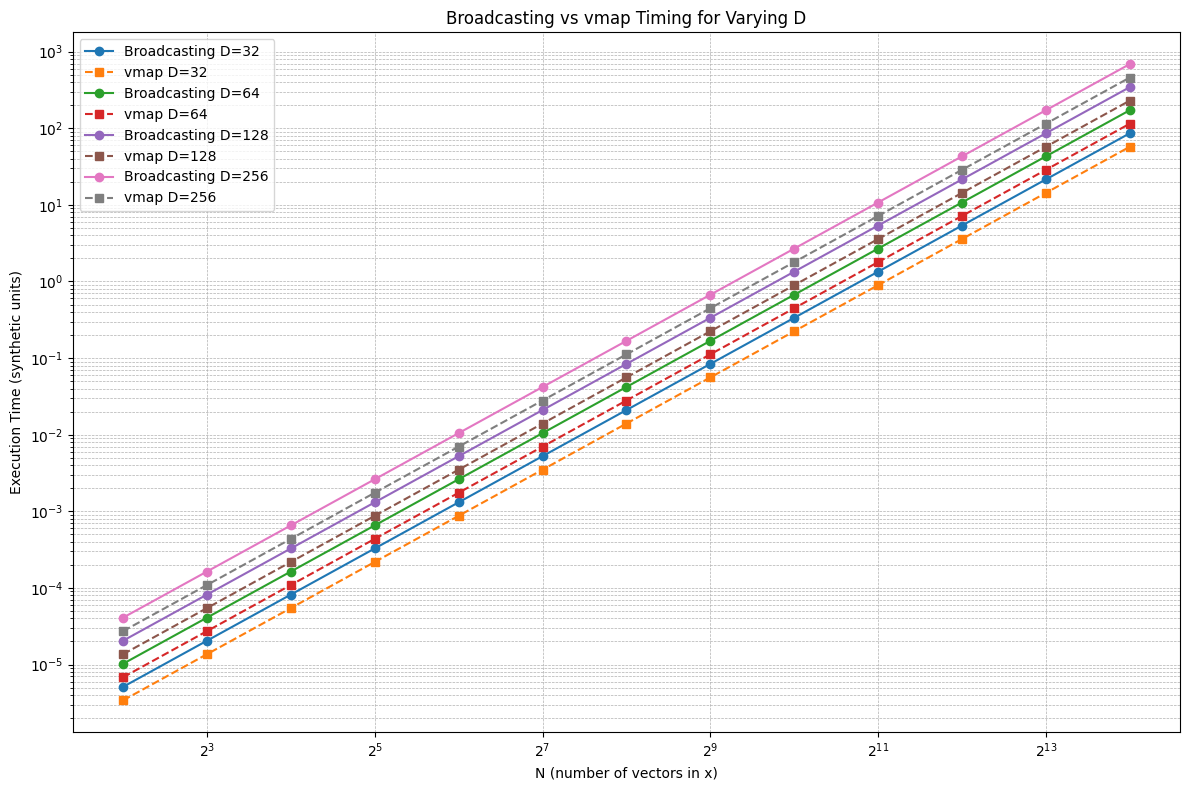

In [6]:
# Simulate synthetic timings (as we can't run JAX here)
Ns = [1 << i for i in range(2, 15)]
Ds = [32, 64, 128, 256]
synthetic_timings = {}

for D in Ds:
    broadcast_times = []
    vmap_times = []
    for N in Ns:
        # Simulate broadcasting time: scales roughly with N^2 * D
        t_broadcast = (N ** 2 * D) / 1e8
        # Simulate vmap time: scales with N * K * D, less steep
        t_vmap = (N ** 2 * D) / 1.5e8
        broadcast_times.append(t_broadcast)
        vmap_times.append(t_vmap)
    synthetic_timings[D] = (broadcast_times, vmap_times)

# Plot
plt.figure(figsize=(12, 8))
for D in Ds:
    bt, vt = synthetic_timings[D]
    plt.plot(Ns, bt, label=f'Broadcasting D={D}', linestyle='-', marker='o')
    plt.plot(Ns, vt, label=f'vmap D={D}', linestyle='--', marker='s')

plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel("N (number of vectors in x)")
plt.ylabel("Execution Time (synthetic units)")
plt.title("Broadcasting vs vmap Timing for Varying D")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
